In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pjr import *
import string
from timeit import default_timer as timer

pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getZAMP (fspec, vname, levs):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    #lat1 = fspec['lat']
    #lon1 = fspec['lon']
    #lev1 = fspec['lev']

    #Fxav = cdutil.averager(F,axis="x")
    #print "Txav=", Txav.info()

    ps = fspec('PS',squeeze=1)
    hyam = fspec('hyam',squeeze=1)
    hybm = fspec('hybm',squeeze=1)

    start = timer()
    P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
    P = P/100.; P.units = "hPa"
    stop1 = timer()
    print  "reconstruct P time = ", stop1-start
    FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
    stop2 = timer()
    print "interp time", stop2-stop1

    #print "FP1.info", FP1.info()
    FP1xav = cdutil.averager(FP1,axis="x")
    return FP1xav;



In [3]:
# identify the levels that we will interpolate to
levs = findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to
vname = "U"
vnameo = "ua"
vname = "T"
vnameo = "ta"
seas = "DJF"

dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1

dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2

g2 = cdms2.open(jname2)
#print g2
TP2xav = getZAMP (g2, vname, levs)
levsp2 = TP2xav.getAxis(0)
lat2 = TP2xav.getAxis(1)
#print "lat2", lat2
#plotZMf(TP2xav, lat2, levsp2)

print "jname1", jname1
g1 = cdms2.open(jname1);
#varlist = g1.listvariables();
#dims = g1.listdimension();
#print dims;
#print "\n".join(s for s in varlist if 'Z' in s) # find vars that contain 'Z'
#print varlist;
#print "levs",levs
TP1xav = getZAMP (g1, vname, levs)
# print "TP1xav", TP1xav

levsp1 = TP1xav.getAxis(0)
lat1 = TP1xav.getAxis(1)
#print "lat1", lat1
#print "levsp1", levsp1

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
g0 = cdms2.open(jname0)
ltit0 = "MERRA2"
print "jname0", jname0
g0 = cdms2.open(jname0);
varlist = g0.listvariables();
dims = g0.listdimension();
#print dims;
#print "\n".join(s for s in varlist if 'T' in s) # find vars that contain 'Z'
print varlist;

T0 =  g0(vnameo,squeeze=1)            # extract fields, remove dimensions length one

TP0 = T0.pressureRegrid(nlevs) # vertical regrid
TM0 = g2(vname,squeeze=1) # get a model grid so we can regrid obs
TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
# vertical regridding seems to lose the mask so add one back in
list = (TP0 > 0.9*TP0.missing_value) 
TP0.mask = list # make sure the missing vales are masked

# the following line does not work
#TP0 = T.pressureRegrid(nlevs,missing=TP0.missing_value)
#print "TP0.mask", TP0.mask
#print "TP0.info()", TP0.info()

TP0xav = cdutil.averager(TP0,axis="x")
levsp0 = TP0xav.getAxis(0)
lat0 = TP0xav.getAxis(1)
#print "lat0", len(lat0), lat0
#print "TP0xav range", TP0xav.min(), TP0xav.max()
#plotZMf(TP0xav, lat0, levsp0)

DT2xav = TP2xav - TP0xav
DT1xav = TP1xav - TP0xav


levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_DJF_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_DJF_climo.nc
xxx


/global/project/projectdirs/acme/software/anaconda_envs/cori/base/envs/e3sm_unified_1.2.4_py2.7_nox/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


reconstruct P time =  1.64980006218


/global/project/projectdirs/acme/software/anaconda_envs/cori/base/envs/e3sm_unified_1.2.4_py2.7_nox/lib/python2.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


interp time 65.9415709972
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_DJF_climo.nc
xxx
reconstruct P time =  0.36518406868
interp time 27.6879630089
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_DJF_1980_2016_climo.nc
['va', 'rsds', 'tas', 'rsdscs', 'zg', 'hfss', 'lon_bnds', 'height', 'rlutcs', 'prw', 'hfls', 'pr', 'rlut', 'climatology_bnds', 'rlus', 'rlds', 'vas', 'lat_bnds', 'uas', 'ta', 'psl', 'rsdt', 'hur', 'rsutcs', 'tauv', 'tauu', 'rsus', 'wap', 'ua', 'rsut']


dlevs [-14. -12. -10.  -8.  -6.  -4.  -2.   2.   4.   6.   8.  10.  12.  14.]


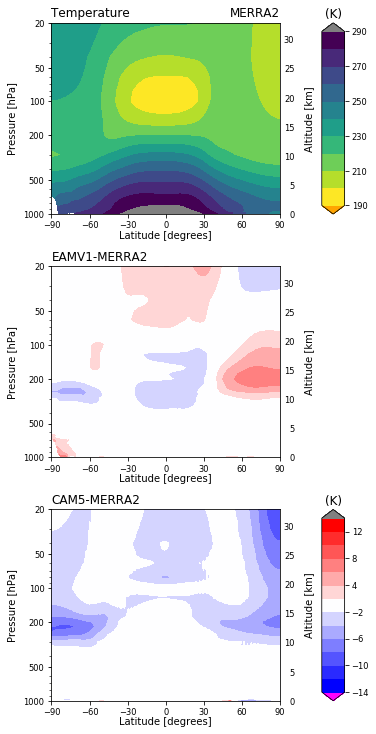

In [4]:
#import colorcet as cc
fig = plt.figure(figsize=(5., 10.), facecolor='white')
axest = fig.add_subplot(311)
axesm = fig.add_subplot(312)
axesb = fig.add_subplot(313)
#print "longname", TP0xav.long_name, TP0xav.title
#plotOpt = {'levels':np.arange(170.,330.,10.),'units':'K','title':'Temperature'} #,
#         'ybot':800.,'ytop':500.}
#plotOpt = {}
dlevs = findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
#dlevs = findNiceContours(np.array([DT2xav,DT2xav]),20,rmClev=0.,sym=True)
print "dlevs", dlevs
#print "TP0xav.info", TP0xav.info
#print "plotOpt",plotOpt
cmap = plt.cm.PiYG
cmap = plt.cm.viridis_r
plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':TP1xav.long_name,'rtitle':ltit0,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest)
cmap = diverge_map()
plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

# show plot
#plt.show()
plt.savefig("test3a.pdf",type="pdf")

In [6]:
# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
g0 = cdms2.open(jname0)
ltit0 = "MERRA2"
print "jname0", jname0
g0 = cdms2.open(jname0);
varlist = g0.listvariables();
dims = g0.listdimension();
#print dims;
#print "\n".join(s for s in varlist if 'T' in s) # find vars that contain 'Z'
print varlist;

dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1
g1 = cdms2.open(jname1);
#varlist = g1.listvariables();
#dims = g1.listdimension();
#print dims;
#print "\n".join(s for s in varlist if 'Z' in s) # find vars that contain 'Z'
#print varlist;
#print "levs",levs

dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2
g2 = cdms2.open(jname2)


jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_DJF_1980_2016_climo.nc
['va', 'rsds', 'tas', 'rsdscs', 'zg', 'hfss', 'lon_bnds', 'height', 'rlutcs', 'prw', 'hfls', 'pr', 'rlut', 'climatology_bnds', 'rlus', 'rlds', 'vas', 'lat_bnds', 'uas', 'ta', 'psl', 'rsdt', 'hur', 'rsutcs', 'tauv', 'tauu', 'rsus', 'wap', 'ua', 'rsut']
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_DJF_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_DJF_climo.nc


dlevs [-14. -12. -10.  -8.  -6.  -4.  -2.   2.   4.   6.   8.  10.  12.  14.]


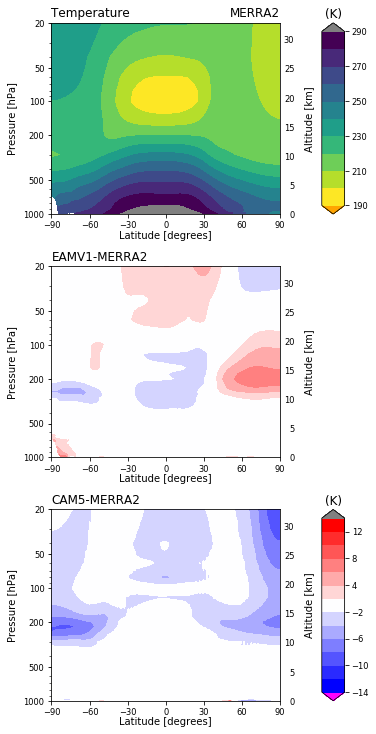

In [4]:
#import colorcet as cc
fig = plt.figure(figsize=(5., 10.), facecolor='white')
axest = fig.add_subplot(311)
axesm = fig.add_subplot(312)
axesb = fig.add_subplot(313)
#print "longname", TP0xav.long_name, TP0xav.title
#plotOpt = {'levels':np.arange(170.,330.,10.),'units':'K','title':'Temperature'} #,
#         'ybot':800.,'ytop':500.}
#plotOpt = {}
dlevs = findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
#dlevs = findNiceContours(np.array([DT2xav,DT2xav]),20,rmClev=0.,sym=True)
print "dlevs", dlevs
#print "TP0xav.info", TP0xav.info
#print "plotOpt",plotOpt
cmap = plt.cm.PiYG
cmap = plt.cm.viridis_r
plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':TP0xav.long_name,'rtitle':ltit0,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest)
cmap = diverge_map()
plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

# show plot
#plt.show()
plt.savefig("test3a.pdf",type="pdf")

In [7]:
T0 =  g0(vnameo,squeeze=1)            # get obs
TP0 = T0.pressureRegrid(nlevs) # vertical regrid
TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
# vertical regridding seems to lose the mask so add one back in
list = (TP0 > 0.9*TP0.missing_value) 
TP0.mask = list # make sure the missing vales are masked
TP0xav = cdutil.averager(TP0,axis="x")
levsp0 = TP0xav.getAxis(0)
lat0 = TP0xav.getAxis(1)

TP1xav = getZAMP (g1, vname, levs)
levsp1 = TP1xav.getAxis(0)
lat1 = TP1xav.getAxis(1)

TP2xav = getZAMP (g2, vname, levs)
levsp2 = TP2xav.getAxis(0)
lat2 = TP2xav.getAxis(1)

DT2xav = TP2xav - TP0xav
DT1xav = TP1xav - TP0xav


xxx
reconstruct P time =  0.202692985535
interp time 27.595072031
xxx
reconstruct P time =  0.951849937439
interp time 67.2772111893


diff contour levs [-14. -12. -10.  -8.  -6.  -4.  -2.   2.   4.   6.   8.  10.  12.  14.]


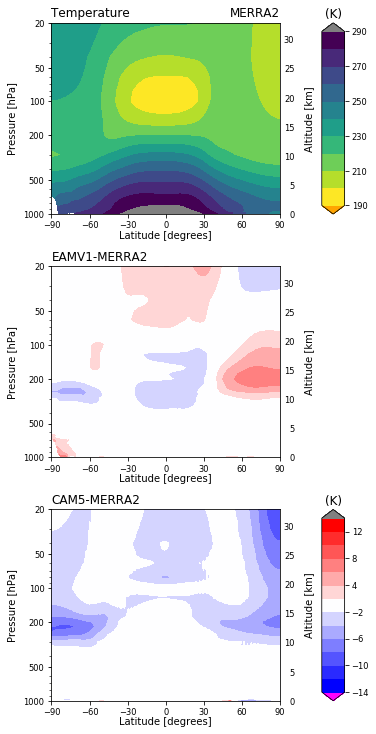

In [46]:
#import colorcet as cc
fig = plt.figure(figsize=(5., 10.), facecolor='white')
axest = fig.add_subplot(311)
axesm = fig.add_subplot(312)
axesb = fig.add_subplot(313)

dlevs = findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
print "diff contour levs", dlevs

cmap = plt.cm.viridis_r
plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':TP0xav.long_name,'rtitle':ltit0,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest)
cmap = diverge_map()
plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

# show plot
#plt.show()
plt.savefig("test3a.pdf",type="pdf")

levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_ANN_climo.nc
i Relative Humidity
xxx
reconstruct P time =  0.174998998642
interp time 22.1979539394
xxx
reconstruct P time =  1.25773096085
interp time 52.5380089283
ZAVG_Relative Humidity_ANN_MERRAvsModels.pdf
diff contour levs [-40. -35. -30. -25. -20. -15. -10.  -5.   5.  10.  15.  20.  25.  30.
  35.  40.]
i Temp

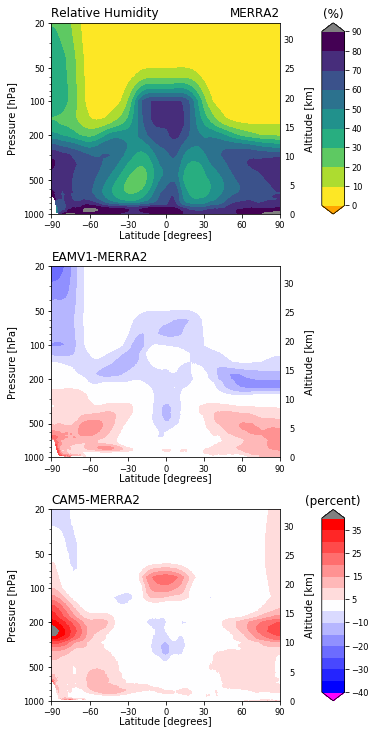

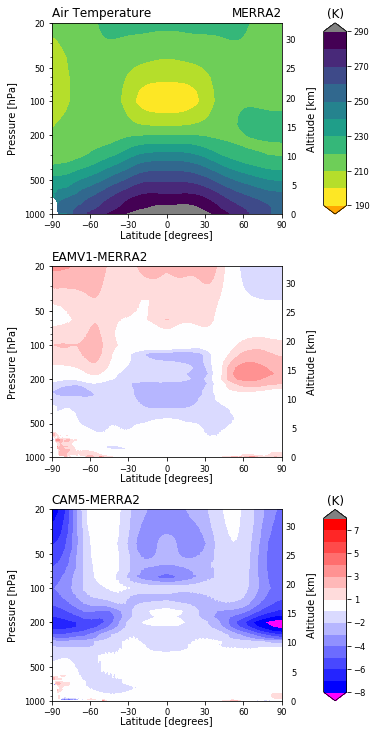

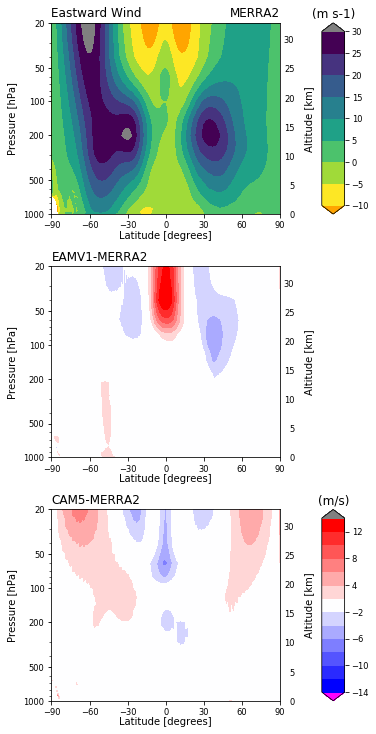

In [52]:
from pprint import pprint

class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

            
def getdat (g0, vnameo, g1, g2, vname):
    
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TP0 = T0.pressureRegrid(nlevs) # vertical regrid
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
    # vertical regridding seems to lose the mask so add one back in
    list = (TP0 > 0.9*TP0.missing_value) 
    TP0.mask = list # make sure the missing vales are masked
    TP0xav = cdutil.averager(TP0,axis="x")
    levsp0 = TP0xav.getAxis(0)
    lat0 = TP0xav.getAxis(1)

    TP1xav = getZAMP (g1, vname, levs)
    levsp1 = TP1xav.getAxis(0)
    lat1 = TP1xav.getAxis(1)

    TP2xav = getZAMP (g2, vname, levs)
    levsp2 = TP2xav.getAxis(0)
    lat2 = TP2xav.getAxis(1)

    DT2xav = TP2xav - TP0xav
    DT1xav = TP1xav - TP0xav

    return TP0xav, DT1xav, DT2xav;

def pltdat (TP0xav, DT1xav, DT2xav):

    fig = plt.figure(figsize=(5., 10.), facecolor='white')
    axest = fig.add_subplot(311)
    axesm = fig.add_subplot(312)
    axesb = fig.add_subplot(313)

    dlevs = findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
    print "diff contour levs", dlevs

    cmap = plt.cm.viridis_r
    plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'cmap':cmap,'ltitle':TP0xav.long_name,'rtitle':ltit0,'cabv':'grey','cbel':'orange','colorbar':'right'}, axesa=axest)
    cmap = diverge_map()
    plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'rightnd'})
    plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'cabv':'grey','colorbar':'right'})
    plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

    # show plot
    #plt.show()
#----------------------------------------------------------
# the metadata that controls the analysis and plotting
# identify the levels that we will interpolate to
levs = findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to
seas = "ANN"

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
ltit0 = "MERRA2"
print "jname0", jname0

dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1

dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2  

vlist = [] #create an empty list
vlist.append(vsets("Relative Humidity", "RELHUM","hur"))
vlist.append(vsets("Temperature", "T", "ta"))
vlist.append(vsets("Zonal Wind", "U", "ua"))

#------------------------------------------
# open the files and make the plots

g0 = cdms2.open(jname0);
varlist = g0.listvariables();
dims = g0.listdimension();
g1 = cdms2.open(jname1);
g2 = cdms2.open(jname2)

for i in vlist:
    print "i", i.name
    pltname = "ZAVG_"+i.name+"_"+seas+"_MERRAvsModels.pdf"
    TP0xav, DT1xav, DT2xav = getdat(g0, i.oname, g1, g2, i.mname)
    print pltname
    pltdat(TP0xav, DT1xav, DT2xav)
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    #break